<h1 style="text-align:center;"><b>Laboratorio 1</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Importar datos

In [14]:
#CONSUMO

archivo = 'Datos/Consumo.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
consumo = df[columnas_deseadas]
print('\nDatos filtrados:')
consumo.head()

train_size = int(len(consumo) * 0.7)
train_consumo = consumo[0:train_size]
test_consumo = consumo[train_size:len(consumo)]
print(train_consumo)


Datos filtrados:
            Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2000-01-01          308156.82         202645.20           634667.06
2000-02-01          307766.31         205530.96           642380.66
2000-03-01          331910.29         229499.56           699807.25
2000-04-01          315648.08         210680.40           586803.98
2000-05-01          319667.97         208164.34           656948.20
...                       ...               ...                 ...
2017-02-01          526888.94         453665.32                0.00
2017-03-01          592249.34         523943.60                0.00
2017-04-01          530345.96         500063.03                0.00
2017-05-01          588861.62         516884.37                0.00
2017-06-01          549378.05         478491.95                0.00

[210 rows x 3 columns]


In [15]:
#IMPORTACIONES

archivo = 'Datos/Importaciones.xlsx'
df = pd.read_excel(archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

#Se saca las columnas necesarias
columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel alto azufre']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
importaciones.head()

train_size = int(len(importaciones) * 0.7)
train_importa = importaciones[0:train_size]
test_importa = importaciones[train_size:len(importaciones)]
print(train_importa)


Datos filtrados:
            Gasolina superior  Gasolina regular  Diesel alto azufre
Fecha                                                              
2001-01-01          373963.96         177776.50           566101.99
2001-02-01          243091.07         123115.99           489525.80
2001-03-01          312084.38         161726.42           575559.68
2001-04-01          285054.89         127338.74           437745.42
2001-05-01          300913.67         168730.19           552609.13
...                       ...               ...                 ...
2017-05-01          442311.09         386088.18           889926.86
2017-06-01          582374.34         519389.66           902659.00
2017-07-01          769214.06         433026.08           994338.30
2017-08-01          607368.72         592103.31           846696.35
2017-09-01          401678.98         316435.22           925397.87

[201 rows x 3 columns]


## Convertir en series de tiempo

In [16]:
#Gasolina superior
ts_consumo_superior = train_consumo['Gasolina superior']
ts_importa_superior = train_importa['Gasolina superior']

#Gasolina regular
ts_consumo_regular = train_consumo['Gasolina regular']
ts_importa_regular = train_importa['Gasolina regular']

#Diesel alto azufre
ts_consumo_diesel = train_consumo['Diesel alto azufre']
ts_importa_diesel = train_importa['Diesel alto azufre']

## Análisis exploratorio

In [17]:
print("Consumo")
print(ts_consumo_superior.describe(),ts_consumo_regular.describe(),ts_consumo_diesel.describe())

print("\nImportaciones")
print( ts_importa_superior.describe(),  ts_importa_regular.describe(),  ts_importa_diesel.describe())

Consumo
count       210.000000
mean     410311.560689
std       65549.202310
min      300242.781667
25%      375521.225000
50%      394668.375000
75%      431846.040000
max      615251.510000
Name: Gasolina superior, dtype: float64 count       210.000000
mean     270275.421701
std       90305.385492
min      160741.900000
25%      205770.337500
50%      236600.710000
75%      297885.425000
max      524242.310000
Name: Gasolina regular, dtype: float64 count    2.100000e+02
mean     7.349019e+05
std      1.785706e+05
min      0.000000e+00
25%      6.613094e+05
50%      7.311107e+05
75%      8.143484e+05
max      1.149175e+06
Name: Diesel alto azufre, dtype: float64

Importaciones
count       201.000000
mean     430704.408294
std      125344.248075
min      193484.500000
25%      341700.480000
50%      419029.170000
75%      523730.310000
max      771024.110000
Name: Gasolina superior, dtype: float64 count       201.000000
mean     280195.135641
std      127263.923759
min       81015.3000

Se puede ver que la gasolina Diesel tiene la media de consumo más alta (735 000), casi el doble de la media de consumo de la gasolina superior (420 000). A su vez, la gasolina superior tiene una media de consumo de casi el doble de la media de la gasolina regular (270 000). La desviación estándar coincide en las diferencias (es decir, el diesel tiene la desviación más grande, seguido de superior y por último regular). 

En cuanto a las importaciones, se mantiene el orden. Se puede ver que la gasolina tiene uan media de importación de alrededor de 800 000, mientras que la gasdolina superior tiene una de alrededor de 430 000. El promedio de importaciones de la gaslolina regular es de alrededor 280 000. 

Se puede observar que el valor de la media consumo medio es alrededor de 10 000 menor que las importaciones.

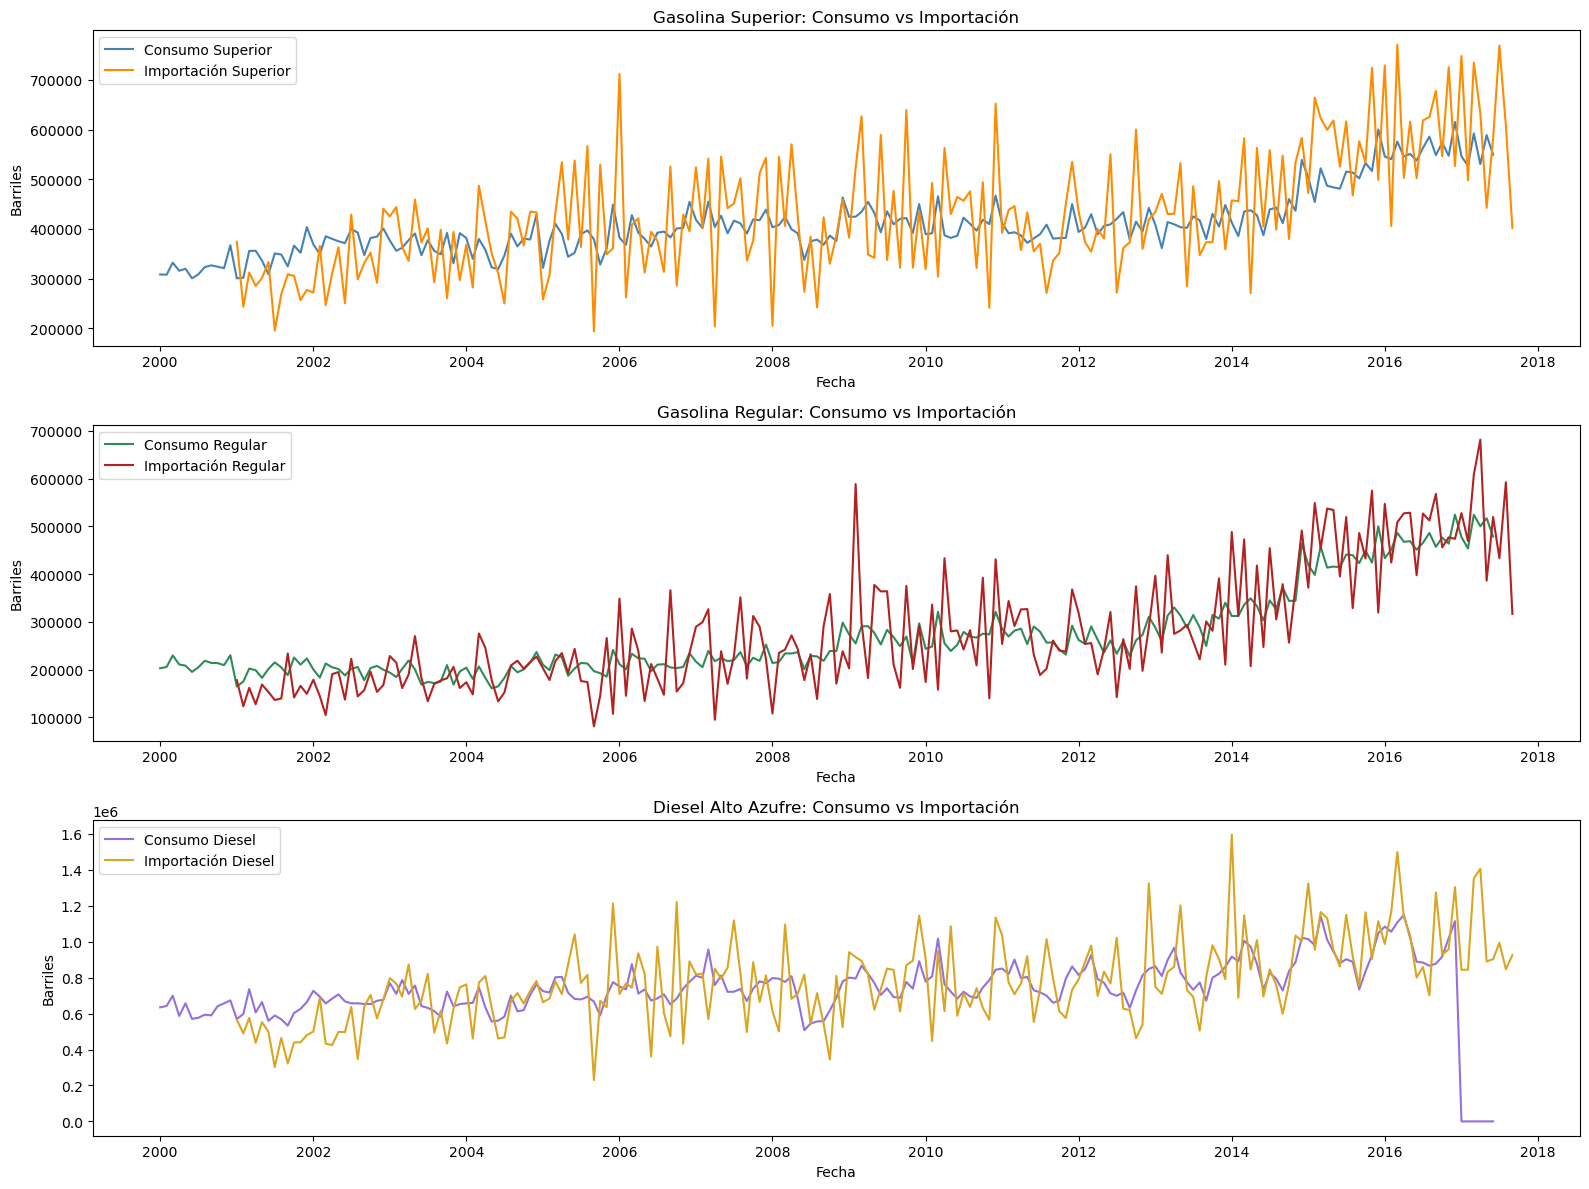

In [18]:
#Gasolina Superior
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(ts_consumo_superior, label='Consumo Superior', color='steelblue')
plt.plot(ts_importa_superior, label='Importación Superior', color='darkorange')
plt.title('Gasolina Superior: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Gasolina Regular
plt.subplot(3, 1, 2)
plt.plot(ts_consumo_regular, label='Consumo Regular', color='seagreen')
plt.plot(ts_importa_regular, label='Importación Regular', color='firebrick')
plt.title('Gasolina Regular: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()

#Diesel Alto Azufre
plt.subplot(3, 1, 3)
plt.plot(ts_consumo_diesel, label='Consumo Diesel', color='mediumpurple')
plt.plot(ts_importa_diesel, label='Importación Diesel', color='goldenrod')
plt.title('Diesel Alto Azufre: Consumo vs Importación')
plt.xlabel('Fecha')
plt.ylabel('Barriles')
plt.legend()
plt.tight_layout()
plt.show()

### Análisis de normalidad

In [19]:
from scipy.stats import shapiro
stat1, p1 = shapiro(ts_consumo_superior)
stat2, p2 = shapiro(ts_importa_superior)
stat3, p3 = shapiro(ts_consumo_regular)
stat4, p4 = shapiro(ts_importa_regular)
stat5, p5 = shapiro(ts_consumo_diesel)
stat6, p6 = shapiro(ts_importa_diesel)

print(p1, p2, p3, p4, p5, p6)

9.136041845334487e-10 0.0004653665294097945 2.3850258324972416e-14 4.176536100682387e-09 9.889035453091424e-14 0.006733239063708438


El valor-p es menor a 0.05 para todas las variables, lo que indica que todas estan distribuidas normalmente

### Meses en los que más importaciones hay

In [27]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

promedio_consumo_superior = ts_consumo_superior.groupby(ts_consumo_superior.index.month).mean()
promedio_consumo_superior.index = meses
print('Consumo\n')
print(promedio_consumo_superior)

promedio_consumo_regular = ts_consumo_regular.groupby(ts_consumo_regular.index.month).mean()
promedio_consumo_regular.index = meses
print(promedio_consumo_regular)

promedio_consumo_diesel = ts_consumo_diesel.groupby(ts_consumo_diesel.index.month).mean()
promedio_consumo_diesel.index = meses
print(promedio_consumo_diesel)

print('\nImportaciones')

promedio_importa_superior = ts_importa_superior.groupby(ts_importa_superior.index.month).mean()
promedio_importa_superior.index = meses
print(promedio_importa_superior)

promedio_importa_regular = ts_importa_regular.groupby(ts_importa_regular.index.month).mean()
promedio_importa_regular.index = meses
print(promedio_importa_regular)

promedio_importa_diesel = ts_importa_diesel.groupby(ts_importa_diesel.index.month).mean()
promedio_importa_diesel.index = meses
print(promedio_importa_diesel)

Consumo

Enero         405314.055417
Febrero       393553.492639
Marzo         432881.184750
Abril         410983.467639
Mayo          407285.673194
Junio         389831.328194
Julio         409700.649853
Agosto        412437.791029
Septiembre    391072.384167
Octubre       412408.911029
Noviembre     400286.742206
Diciembre     459278.351814
Name: Gasolina superior, dtype: float64
Enero         267222.822963
Febrero       258266.025185
Marzo         293821.399074
Abril         281669.284769
Mayo          270847.616296
Junio         262441.087407
Julio         264106.709020
Agosto        263998.429020
Septiembre    251575.148754
Octubre       267156.443137
Noviembre     257972.788725
Diciembre     303485.205742
Name: Gasolina regular, dtype: float64
Enero         753603.974788
Febrero       741923.932275
Marzo         827589.773466
Abril         754171.763763
Mayo          723396.700926
Junio         649399.058095
Julio         699532.916459
Agosto        703040.623754
Septiembre    65

Se puede observar que aunque el cambio no es tan signficativo si existen diferencias por mes. Por ejemplo, el consumo de gasolina sin importar el tipo es mas alto en diciembre y bajo en febrero. Para las importaciones el diesel tiene un valor mucho mas alto en diciembre, pero los demas tipos no demuestran tanta diferencia.